# Résolution numérique d’une EDS : étude d’erreur et simulation.

Alois Marechal et Pineau Benjamin

In [2]:
# Importation des modules

import numpy as np
import matplotlib.pyplot as plt
from random import random

In [3]:
# Définition des constantes

theta = 1
mu = 1.2
sigma = 0.3
a = 0
b = 2

On va chercher à simuluer un processus d'Orstein - Ulhenbeck $r$ solution de l'équation différentielle stochastique :
\begin{equation}
\begin{cases}
\; \text{d}r_t = -\theta(r_t - \mu)\text{d}t + \sigma\text{d}W_t, \quad t > 0 \\
\; r_{t = 0} = r_0 \in \mathbb{R}
\end{cases}
\end{equation}
grâce à une méthode exacte et une méthode approchée

## Simulation numérique avec une méthode exacte

On utilise l'expression exacte du processus vérifiant (1):
$$
r_t = r_0e^{-\theta t } + \mu(1 - e^{- \theta t}) + \int_{0}^{t}\sigma e^{\theta(s - t)}  \,dW_s 
$$
ce qui revient à implémenter l'algorithme suivant :
$$
X_{t+\Delta t}=X_t e^{-\theta \Delta t}+\mu\left(1-e^{-\theta \Delta t}\right)+\sigma \sqrt{\frac{1-e^{-2 \theta \Delta t}}{2 \theta}} Z
$$
où $Z \leadsto  \mathcal{N}(0, 1)$

(Les calculs sont explicités dans le rapport)

In [4]:
# Méthode exacte

def simu_exact(r0, t):
    N = len(t)
    r = np.zeros(N)
    for n in range(N-1):
        dt = t[n+1] - t[n]
        sigma_tilde = sigma**2/(2*theta)*(1 - np.exp(-2*theta*dt))
        Z = np.sqrt(sigma_tilde)*np.random.normal(0, 1)
        r[n+1] = np.exp(-theta*dt)*(r[n] - mu) + mu + Z
    return r

Text(0.5, 1.0, "Simulation du processus d'Orstein-Ulhenbeck - méthode exacte")

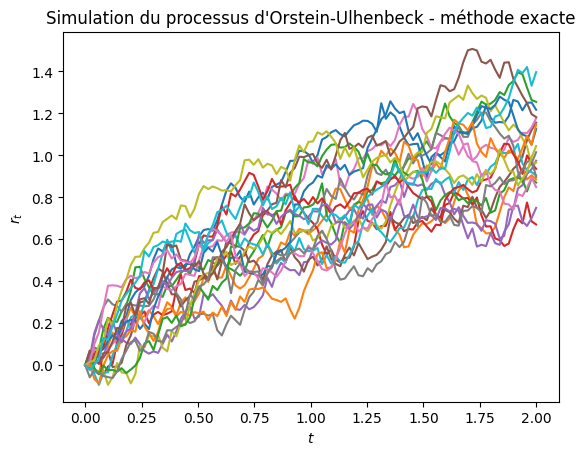

In [12]:
t = np.linspace(a, b, 100)
for i in range(20):
    plt.plot(t, simu_exact(0, t))
plt.ylabel('$r_t$')
plt.xlabel('$t$')
plt.title('Simulation du processus d\'Orstein-Ulhenbeck - méthode exacte')

## Simulation numérique avec une méthode approchée

On va utiliser le schéma d'Euler - Maruyana pour simuler numériquement le processus d'Orstein-Ulhenbeck : 
$$
X_{n+1} = X_n + b(t_n, X_n)\Delta t + \sigma(t_n, X_n)\Delta W_n
$$
Dans notre cas, le schéma revient à faire l'algorithme suivant :
$$
r_{n+1} = r_n - \theta(r_n - \mu)\Delta t + \sigma \Delta W
$$

**Remarque :** on pourrait également utiliser le schéma de Milstein :
$$
r_k^{n+1} = r_k^{n} + b_k(t^n, r^n)\Delta t + \sigma_{kk}(t^n, r^n)\Delta W_k^n + \frac{1}{2}\frac{\partial \sigma_{kk}}{\partial x_k}(t^n, r^n)\big((\Delta W_k^n)^2 - \Delta t\big), \quad \forall k
$$
Cependant dans notre cas d'étude $\sigma$ est constant. De ce fait $ \frac{\partial \sigma_{kk}}{\partial x_k}= 0$ et on retombe sur le schéma d'Orstein-Ulhenbeck

In [6]:
# Méthode approchée : schéma d'Euler-Maruyama

def simu_EM(r0, t):
    N = len(t)
    r = np.zeros(N)
    r[0] = r0
    for n in range(N-1):
        dt = t[n+1] - t[n]
        dW = np.sqrt(dt)*np.random.normal(0, 1)
        r[n+1] = r[n] -theta*(r[n] - mu)*dt + sigma*dW
    return r

Text(0.5, 1.0, "Simulation du processus d'Orstein-Ulhenbeck - méthode approchée")

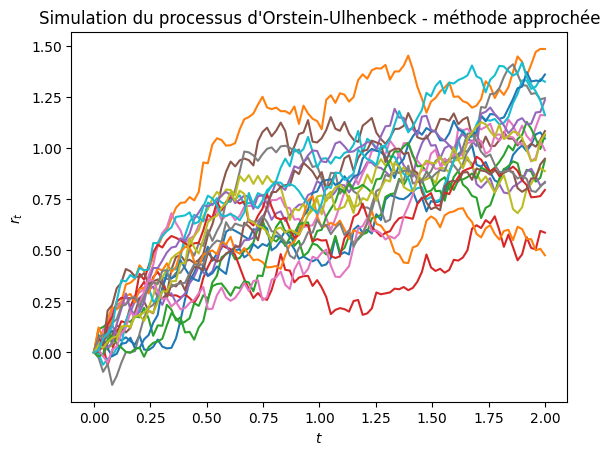

In [7]:
t = np.linspace(a, b, 100)
for i in range(20):
    plt.plot(t, simu_EM(0, t))
plt.ylabel('$r_t$')
plt.xlabel('$t$')
plt.title('Simulation du processus d\'Orstein-Ulhenbeck - méthode approchée')

## Etude de l'erreur et de la convergence forte

On note l'erreur d'approximation $X_t^{\Delta t}$ de $X_t$ par $\mathcal{E}_t = \mathbb{E}((X_t - X_t^{\Delta t})^2)$. On montre dans le rapport le résultat suivant :
$$
\underset{t \in I}{\sup} \mathcal{E_t}\lesssim \mathcal{O}(\Delta t)
$$
L'idée est ici d'illustrer ce résultat de convergence forte

Dans notre cas d'étude, la solution exacte est accessible (cf rapport). De ce fait, on peut facilement estimer l'erreur d'approximation avec une méthode de Monte Carlo. Il suffit alors de prendre le sup pour les instants du maillage temporel. Ainsi :
$$
\underset{t \in I}{\sup} \mathbb{E}((X_t - X_t^{\Delta t})^2) \simeq \underset{0 \leq n \leq N}{\sup} \frac{1}{M}\sum_{i = 1}^{M}\left\lVert X_{t_n}(\omega_i) - X^n(\omega_i)\right\rVert^2
$$

**Remarque** : $X_{t_n}(\omega_i)$ et $X^n(\omega_i)$ sont des réalisations indépendantes de $X_t^{\Delta t}$ et $X_t$ simulé pour une même trajectoire du mouvement brownien $W(\omega_i)$. Il faut donc légèrement modifier les algorithmes précédents pour faire en sorte de toujours utiliser la même réalisation $W(\omega_i)$ lorsque l'on simule les $X_{t_n}(\omega_i)$ et les $X(\omega_i)$

In [8]:
# Méthode exacte

def simu_exact_error(r0, t, Z):
    N = len(t)
    r = np.zeros(N)
    for n in range(N-1):
        dt = t[n+1] - t[n]
        sigma_tilde = sigma**2/(2*theta)*(1 - np.exp(-2*theta*dt))
        Z_t = np.sqrt(sigma_tilde)*Z
        r[n+1] = np.exp(-theta*dt)*(r[n] - mu) + mu + Z_t
    return r

In [9]:
# Méthode approchée : schéma d'Euler-Maruyama

def simu_EM_error(r0, t, Z):
    N = len(t)
    r = np.zeros(N)
    r[0] = r0
    for n in range(N-1):
        dt = t[n+1] - t[n]
        dW = np.sqrt(dt)*Z
        r[n+1] = r[n] -theta*(r[n] - mu)*dt + sigma*dW
    return r

0.2 10
0.1 20
0.05 40
0.02 100
0.01 200
0.005 400
0.002 1000
0.001 2000


Text(0.5, 1.0, "Evolution de l'erreur en fonction de $\\Delta t$")

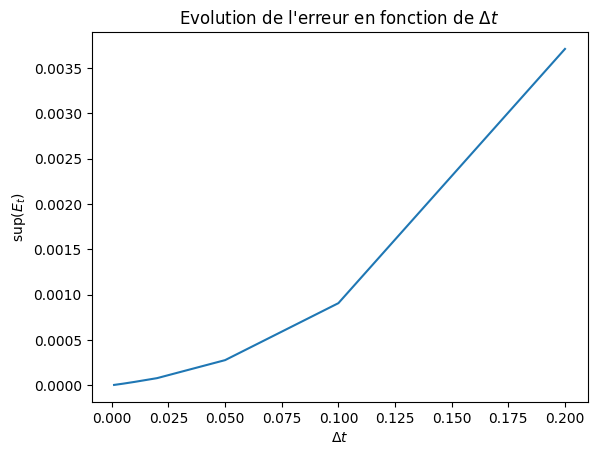

In [10]:
M = 1000
liste_dt = [0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
liste_error = []

for dt in liste_dt:
    t = np.linspace(a, b, int(b/dt))
    liste_EM = []
    liste_exact = []
    print(dt, int(b/dt))
    for m in range(M):
        Z = np.random.normal(0, 1)
        EM = simu_EM_error(0, t, Z)
        exact = simu_exact_error(0, t, Z)
        liste_EM.append(EM)
        liste_exact.append(exact)
        
    error = 1/M * sum( [(liste_EM[i] - liste_exact[i])**2 for i in range(0, M)] )
    error_max = np.max(error)
    liste_error.append(error_max)

liste_dt = np.array(liste_dt)
liste_error = np.array(liste_error)
plt.plot(liste_dt, liste_error)
plt.xlabel('$\Delta t$')
plt.ylabel('sup($E_t)$')
plt.title('Evolution de l\'erreur en fonction de $\Delta t$')

Afin de mieux observer le résultat de convergence énoncé plus tot, on observe l'erreur en la passant au logarithme. En effet, on souhaite observer 
$$
\underset{t \in I}{\sup} \mathcal{E_t}\leq  C\Delta t \Longleftrightarrow \log(\underset{t \in I}{\sup} \mathcal{E_t}) \leq \log(C) + \log(\Delta t)
$$
Il suffira alors de remarquer que $f(t) = \Delta t$ et $g(t) = \underset{t \in I}{\sup} \mathcal{E_t}$ sont deux droites parallèles, qui diffèrent d'un shift (qui représente $\log(C)$)

0.2 10
0.1 20
0.05 40
0.02 100
0.01 200
0.005 400
0.002 1000
0.001 2000


Text(0.5, 1.0, "Evolution de l'erreur en fonction de $\\Delta t$, échelle log")

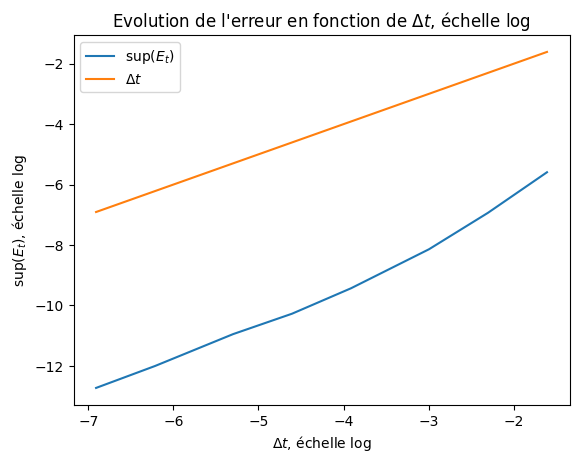

In [13]:
M = 1000
liste_dt = [0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
liste_error = []

for dt in liste_dt:
    t = np.linspace(a, b, int(b/dt))
    liste_EM = []
    liste_exact = []
    print(dt, int(b/dt))
    for m in range(M):
        Z = np.random.normal(0, 1)
        EM = simu_EM_error(0, t, Z)
        exact = simu_exact_error(0, t, Z)
        liste_EM.append(EM)
        liste_exact.append(exact)
        
    error = 1/M * sum( [(liste_EM[i] - liste_exact[i])**2 for i in range(0, M)] )
    error_max = np.max(error)
    liste_error.append(error_max)

liste_dt = np.array(liste_dt)
liste_error = np.array(liste_error)
plt.plot(np.log(liste_dt), np.log(liste_error), label = 'sup($E_t$)')
plt.plot(np.log(liste_dt), np.log(liste_dt), label = '$\Delta t$')
plt.xlabel('$\Delta t$, échelle log')
plt.ylabel('sup($E_t)$, échelle log')
plt.legend()
plt.title('Evolution de l\'erreur en fonction de $\Delta t$, échelle log')